This is for extrapolation version for full phase prediction in MileStone1.

In [12]:
import data1 as data
# import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Full phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 1, 2])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=20.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=20.0, max_iter=250)) 

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])
rf_pcc = ProbabilisticClassifierChain(rf)

# Rulefit
rufit_pcc = RuleFitWrapper()

full_estimators = [lr_ind, lr_pcc, rf_ind, rf_pcc, rufit_pcc]
full_names = ['LR_ind', 'LR_pcc', 'RF_ind', 'RF_pcc', 'rufit_pcc']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result.

In [4]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold
from common import ExtrapolationExperiment, sample_size, GroupDescription
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

extrapolation = ExtrapolationExperiment(full_estimators, 
                                        full_names,
                                        data.x, data.y.replace(-1, 0), data.comp_ids.values,
                                        score=['accuracy', LogLikelihoodEvaluator(2, neg=True), 
                                               sample_size,
                                               GroupDescription(data.comp_descr, 'composition')]).run()

Running experiment with 37 repetitions
*************************************


In [5]:
# import pickle
# cur_save=open('./' + 'extra_37folder_full' + '.p', 'rb')
# interpolation = pickle.load(cur_save)

In [13]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
df = extrapolation.summary()
df['mean_train_error'] = 1- df['mean_train_accuracy']
df['std_train_error'] = df['std_train_accuracy']
df['mean_test_error'] = 1- df['mean_test_accuracy']
df['std_test_error'] = df['std_test_accuracy']

In [14]:
extrapolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss,mean_train_size,std_train_size,mean_test_size,std_test_size
LR_ind,0.383107,0.022709,0.400911,0.400362,2.907224,0.018351,3.477735,2.683668,576.0,25.69479,16.0,25.69479
LR_pcc,0.383107,0.022709,0.400911,0.400362,2.907224,0.018351,3.477735,2.683668,576.0,25.69479,16.0,25.69479
RF_ind,1.000000,0.000000,0.632732,0.379466,0.251015,0.005709,2.598912,3.838806,576.0,25.69479,16.0,25.69479
RF_pcc,0.999623,0.000838,0.677112,0.380346,0.239828,0.006482,2.354019,3.682936,576.0,25.69479,16.0,25.69479
rufit_pcc,0.956150,0.005393,0.615413,0.385426,0.367190,0.012708,2.609125,2.844490,576.0,25.69479,16.0,25.69479


## Get Baseline

* __Logloss__   
For a single sample with true label $y \in \{0,1\}$ and a probability estimate $p=P(y=1)$, the log loss is:
  
$$L = -(y\log(p) + (1-y)\log(1-p))$$.

* __Error Rate__
For a sample of $n$ observations, the probability of $k$ unique observation is $\{p_1, p_2, \dots, p_k\}$. The error rate is:

$$
E_{rr} = 1 - argmax \{p_i: p_i \in \{p_1, \dots, p_k\}\}
$$


In [16]:
# base line
uniq, cnt = np.unique(data.y.values, axis=0, return_counts=True) 
prob = cnt/sum(cnt)
info_logloss = sum(-1*prob * np.log2(prob))
print('Informed logloss: ', info_logloss)

uniprob = np.array([1/16 for _ in range(16)])
uninfo_logloss =  sum(-1*uniprob * np.log2(uniprob))
print('Uninformed logloss: ', uninfo_logloss)

Informed logloss:  2.5225679165070907
Uninformed logloss:  4.0


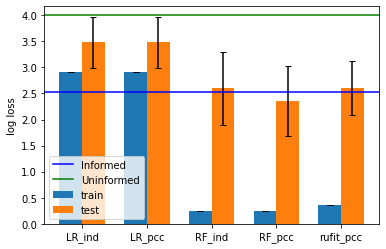

In [17]:
plot_summary('log loss', summ=extrapolation.summary(), baseline=[info_logloss, uninfo_logloss], names=['Informed', 'Uninformed'])

In [18]:
# Error rate base line
uniq, cnts = np.unique(data.y.values, axis=0, return_counts=True)
prob = cnts/sum(cnts)
informed_error = 1- max(prob)
print('Informed Error: ', informed_error)

uninformed_error = sum(uniprob * (1-uniprob))
print('Uninformed Error: ', uninformed_error)

Informed Error:  0.5912162162162162
Uninformed Error:  0.9375


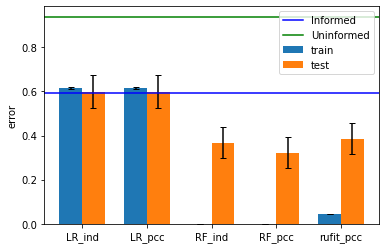

In [20]:
plot_summary('error', summ=df, baseline=[informed_error, uninformed_error], names=['Informed', 'Uninformed']) # below plot is the error rate (1- accuracy)

## Get rules

After $30$ Folder CV, we have $30$ RuleFit estimators. We refit these estimators with whole dataset and select one having minimum log-loss and number of rules.

This is for full-phase, the chain rules first estimate __sphere__ and then treat __sphere__ as a predictor to estimate __worm__. The prediction order is __sphere, worm, vesicle__, and, __other__.

The output rules with coefficient of this notebook are in "Rules/Full_Phase/Interpolation/". The index of the csv names follow the prediction order as above.

In [21]:
def loss(y_test, y_pred):
    y_test = y_test.astype(np.float16)
    y_pred = y_pred.astype(np.float16)
    if len(y_test.shape) == 1:
        N = y_test.shape[0]
        loss = 0
        for i in range(N):
            loss -= ((y_test[i]*np.log(y_pred[i]))+((1.0-y_test[i])*np.log(1.0-y_pred[i])))
            loss = loss/N
    else:
        N,M = y_test.shape
        a=[]
        for m in range(M):
            loss=0
            for i in range(N):
                subloss = ((y_test[i,m]*np.log(y_pred[i,m]))+((1.0-y_test[i,m])*np.log(1.0-y_pred[i,m])))
                if np.isnan(subloss):
                    continue
                loss -= subloss
            loss = loss/N
            a.append(round(loss,8))
        loss = np.mean(a)
    return loss

In [22]:
# choose the best RuleFit
lst = []
for each in extrapolation.fitted_['rufit_pcc']:
    pred = each.predict_proba(data.x)
    res = log_loss(data.y.values, pred)
    lst.append((res, each))
lst.sort()
best_rf = lst[0][1]

In [23]:
dic = best_rf.get_rules(data.x, data.y)
indx = -1
for key, values in dic.items():
    indx += 1
    name = 'Rules/Full_Phase/Extrapolation/'+ str(indx) + "_" + key + '.csv'
    values.to_csv(name, index=False)